# Analysis of the rent dataset

## Overview

Before we start analyzing the data and explaining our intentions, we need to get an overview of the existing data. No matter what we later want to do, we have to clean and prepocess our data in order to work with it 

### Load data

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas.api.types import is_object_dtype
pd.set_option('display.max_columns', None)
%matplotlib inline
from scipy.stats import linregress

In [16]:
df = pd.read_csv("../data/testlizenz-tuebingen-dataliteracy4students_1706088512814.csv", sep=";", encoding='unicode_escape')
df.count() 

angebot_id                    106720
anz_parken                     50795
anz_zimmer                    106517
aus_alarmanlage_janein        106720
aus_bad_dusche_janein         106720
                               ...  
oeig_dachgeschoss_janein      106720
enddate                       105945
aus_balkon_terrasse_janein    106720
aus_wintergarten_janein       106720
aus_garten_eigen_janein       106720
Length: 86, dtype: int64

In [17]:
# include year column
df['year'] = df['startdate'].str[:4] 
df['endyear'] = df['enddate'].str[:4] 
df["month"] = pd.DatetimeIndex(df['startdate']).month

# For linear regression, filter for Tübingen

In [18]:
df["oadr_ort"].unique()

array(['Stuttgart', 'Tübingen', 'Reutlingen'], dtype=object)

In [19]:
df = df[df["oadr_ort"] == "Tübingen"]
df.shape

(9935, 89)

In [20]:
oadr_u2 = df["oadr_u2"].unique().tolist()
cleaned_oadr_2 = [x for x in oadr_u2 if x == x]
cleaned_oadr_2

['Zentrum',
 'Unterjesingen',
 'Bühl',
 'Universität',
 'Wanne',
 'Weilheim',
 'De-Zentrum',
 'Schönblick/Waldhäuser Ost',
 'Weststadt',
 'Österberg/Gartenstraße',
 'Bebenhausen',
 'Denzenberg/Sand',
 'Pfrondorf',
 'Südstadt',
 'Hagelloch',
 'Au/Unterer Wert/Französiches Viertel',
 'Feuerhägle/Mühlenviertel',
 'Lustnau-Zentrum/Herrlesberg/Stäudach',
 'Hirschau',
 'Kilchberg',
 'Neuhalde',
 'Aeule',
 'Gartenstadt']

For the further approach, knowing where the houses are is important. Therefore we will now clean the data and remove all entries that do not have a location attribute.

In [21]:
df_w_loc = df[df['oadr_u2'].notna()]
df_wo_loc = df[df['oadr_u2'].isna()]
print(f"Total number of rows with location: {df_w_loc.shape[0]}")
print(f"Total number of rows without location: {df_wo_loc.shape[0]}")

Total number of rows with location: 6300
Total number of rows without location: 3635


### Adjusting entries
From previous analysis I know that the integer and float values in the dataset are kind of messy, pandas cant interpret them as actual values because they are seperated with **`,`** instead of **`.`** Lets fix this.

In [22]:
df_w_loc

,angebot_id,anz_parken,anz_zimmer,aus_alarmanlage_janein,aus_bad_dusche_janein,aus_bad_gaestewc_janein,aus_bad_mit_fenster_janein,aus_bad_wanne_janein,aus_heiz_alt_erdw_janein,aus_heiz_alt_solar_janein,aus_heiz_alt_pellet_janein,aus_heiz_alt_pumpe_janein,aus_heiz_blockkw_janein,aus_heiz_befeuerung,aus_heiz_fernwaerme_janein,aus_heiz_fussboden_janein,aus_heiz_keine_janein,aus_heiz_system,aus_kamin_janein,aus_kueche_einbau_janein,aus_kueche_offen_janein,aus_kueche_pantry_janein,aus_lift_janein,aus_moebliert_janein,aus_parken_carport_janein,aus_parken_janein,aus_parken_ladestation_janein,aus_parken_stellplaetze_janein,aus_pool_janein,aus_sauna_janein,baujahr,flaeche,etage,etagen,fl_wohnen,kosten,kosten_je_flaeche,kosten_miete_gesamt_janein,kstn_betriebskosten,kstn_betriebskosten_pqm,kstn_heizung,laufzeitw_alle,laufzeitw_geschl,nachfrageart,nutzungsart,oadr_bl,oadr_gkz,oadr_kkz,kstn_nebenkosten,kstn_miete_kalt,kstn_miete_gesamt,kstn_miete_gesamt_pqm,kstn_miete_kalt_pqm,kstn_kaufpreis,kstn_kaufpreis_pqm,kstn_heizung_pqm,oadr_kreis,oadr_ort,oadr_plz,oadr_u1,oadr_u2,objektart,objekttyp,objekttyp_fein,objekttyp_grob,oeig_altbau_janein,zust_saniert_janein,zust_neuwertig_janein,zust_projektiert_janein,zust_modernisierungsjahr,zust_gepflegt_janein,startdate,segment,oeig_wbs_janein,oeig_vermietet_janein,oeig_reihenendhaus_janein3,oeig_neubau_janein,oeig_loggia_janein,oeig_keller_janein,oeig_freistehend_janein,oeig_denkmal_janein,oeig_dachgeschoss_janein,enddate,aus_balkon_terrasse_janein,aus_wintergarten_janein,aus_garten_eigen_janein,year,endyear,month
25,3600015008,NaN,"2,",0,1,0,1,0,0,0,0,0,0,Gas,0,0,0,NaN,0,1,1,0,0,0,0,0,0,0,0,0,1980.0,"58,","2,","3,","58,","870,","15,",0,NaN,NaN,"170,",",2",NaN,miete,Wohn,8,8416041,8416,"170,","870,","1040,","17,93","15,",NaN,NaN,"2,93",Tübingen,Tübingen,72070,Tübingen,Zentrum,Einheit,Wohnung,2-Z-Whg,Wohnung,0,0,1,0,NaN,0,2023-12-30,WHG_M,0,0,0,0,0,1,0,0,1,2024-01-02,0,0,0,2023,2024,12
81,3599773217,1.0,"4,",0,1,1,0,0,0,0,0,0,0,Gas,0,0,0,Zentral,0,1,0,0,0,0,0,1,0,1,0,0,1970.0,"85,","0,","3,","85,","1100,","12,94",0,NaN,NaN,"280,",",5",NaN,miete,Wohn,8,8416041,8416,"70,","1100,","1450,","17,06","12,94",NaN,NaN,"3,29",Tübingen,Tübingen,72070,Unterjesingen,Unterjesingen,Einheit,Wohnung,4-Z-Whg,Wohnung,0,1,0,0,NaN,0,2023-12-28,WHG_M,0,0,0,0,0,1,0,0,-1,NaN,1,0,-1,2023,NaN,12
86,3599734940,1.0,"3,",0,1,0,1,1,0,0,0,0,0,Gas,0,1,0,NaN,0,1,0,0,1,0,0,1,0,0,0,0,2013.0,"70,78","1,","2,","70,78","980,","13,85",0,NaN,NaN,NaN,",3",",3",miete,Wohn,8,8416041,8416,"290,","980,","1270,","17,94","13,85",NaN,NaN,NaN,Tübingen,Tübingen,72072,Bühl,Bühl,Einheit,Wohnung,3-Z-Whg,Wohnung,0,0,1,0,NaN,0,2023-12-27,WHG_M,0,0,0,0,0,1,0,-1,0,2023-12-29,1,0,-1,2023,2023,12
87,3599732598,1.0,"2,",0,0,0,0,0,0,0,0,0,0,Elektro,0,0,0,Zimmer,0,0,0,0,0,0,0,1,0,0,0,0,2023.0,"22,","2,",NaN,"22,","550,","25,",0,NaN,NaN,NaN,",1",",1",miete,Wohn,8,8416041,8416,"50,","550,","600,","27,27","25,",NaN,NaN,NaN,Tübingen,Tübingen,72074,Tübingen,Universität,Einheit,Wohnung,2-Z-Whg,Wohnung,0,0,0,0,NaN,0,2023-12-27,WHG_M,0,0,0,1,0,0,0,-1,0,2023-12-28,0,0,0,2023,2023,12
94,3599699094,NaN,"2,",0,0,0,0,0,0,0,0,0,0,NaN,1,0,0,Zentral,0,1,0,0,0,0,0,0,0,0,0,0,NaN,"56,","-,5","3,","56,","750,","13,39",0,NaN,NaN,NaN,",6",NaN,miete,Wohn,8,8416041,8416,"150,","750,","900,","16,07","13,39",NaN,NaN,NaN,Tübingen,Tübingen,72076,Tübingen,Wanne,Einheit,Wohnung,2-Z-Whg,Wohnung,0,1,0,0,2023.0,0,2023-12-27,WHG_M,0,0,0,0,0,1,0,0,-1,2024-01-04,1,0,0,2023,2024,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106630,1401425145,1.0,"3,",0,0,0,0,0,0,0,0,0,0,Gas,0,0,0,Zentral,0,1,0,0,0,0,0,1,0,0,0,0,NaN,"93,",NaN,NaN,"93,","980,","10,54",0,NaN,NaN,NaN,"19,4","19,4",miete,Woh

In [23]:
for column in df.columns:
    if is_object_dtype(df[column]):
        if df[column].str.contains(',').any(): 
            df[column] = df[column].str.replace(',', '.').astype(float)
            df_w_loc[column] = df_w_loc[column].str.replace(',', '.').astype(float)
df_w_loc

/var/folders/vx/5fczb1z530gfdp5n8z75tyy80000gn/T/ipykernel_3303/1307623920.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_w_loc[column] = df_w_loc[column].str.replace(',', '.').astype(float)
/var/folders/vx/5fczb1z530gfdp5n8z75tyy80000gn/T/ipykernel_3303/1307623920.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_w_loc[column] = df_w_loc[column].str.replace(',', '.').astype(float)
/var/folders/vx/5fczb1z530gfdp5n8z75tyy80000gn/T/ipykernel_3303/1307623920.py:5: SettingWithCopyWarning: 
A value 

,angebot_id,anz_parken,anz_zimmer,aus_alarmanlage_janein,aus_bad_dusche_janein,aus_bad_gaestewc_janein,aus_bad_mit_fenster_janein,aus_bad_wanne_janein,aus_heiz_alt_erdw_janein,aus_heiz_alt_solar_janein,aus_heiz_alt_pellet_janein,aus_heiz_alt_pumpe_janein,aus_heiz_blockkw_janein,aus_heiz_befeuerung,aus_heiz_fernwaerme_janein,aus_heiz_fussboden_janein,aus_heiz_keine_janein,aus_heiz_system,aus_kamin_janein,aus_kueche_einbau_janein,aus_kueche_offen_janein,aus_kueche_pantry_janein,aus_lift_janein,aus_moebliert_janein,aus_parken_carport_janein,aus_parken_janein,aus_parken_ladestation_janein,aus_parken_stellplaetze_janein,aus_pool_janein,aus_sauna_janein,baujahr,flaeche,etage,etagen,fl_wohnen,kosten,kosten_je_flaeche,kosten_miete_gesamt_janein,kstn_betriebskosten,kstn_betriebskosten_pqm,kstn_heizung,laufzeitw_alle,laufzeitw_geschl,nachfrageart,nutzungsart,oadr_bl,oadr_gkz,oadr_kkz,kstn_nebenkosten,kstn_miete_kalt,kstn_miete_gesamt,kstn_miete_gesamt_pqm,kstn_miete_kalt_pqm,kstn_kaufpreis,kstn_kaufpreis_pqm,kstn_heizung_pqm,oadr_kreis,oadr_ort,oadr_plz,oadr_u1,oadr_u2,objektart,objekttyp,objekttyp_fein,objekttyp_grob,oeig_altbau_janein,zust_saniert_janein,zust_neuwertig_janein,zust_projektiert_janein,zust_modernisierungsjahr,zust_gepflegt_janein,startdate,segment,oeig_wbs_janein,oeig_vermietet_janein,oeig_reihenendhaus_janein3,oeig_neubau_janein,oeig_loggia_janein,oeig_keller_janein,oeig_freistehend_janein,oeig_denkmal_janein,oeig_dachgeschoss_janein,enddate,aus_balkon_terrasse_janein,aus_wintergarten_janein,aus_garten_eigen_janein,year,endyear,month
25,3600015008,NaN,2.0,0,1,0,1,0,0,0,0,0,0,Gas,0,0,0,NaN,0,1,1,0,0,0,0,0,0,0,0,0,1980.0,58.00,2.0,3.0,58.00,870.0,15.00,0,NaN,NaN,170.0,0.2,NaN,miete,Wohn,8,8416041,8416,170.0,870.0,1040.0,17.93,15.00,NaN,NaN,2.93,Tübingen,Tübingen,72070,Tübingen,Zentrum,Einheit,Wohnung,2-Z-Whg,Wohnung,0,0,1,0,NaN,0,2023-12-30,WHG_M,0,0,0,0,0,1,0,0,1,2024-01-02,0,0,0,2023,2024,12
81,3599773217,1.0,4.0,0,1,1,0,0,0,0,0,0,0,Gas,0,0,0,Zentral,0,1,0,0,0,0,0,1,0,1,0,0,1970.0,85.00,0.0,3.0,85.00,1100.0,12.94,0,NaN,NaN,280.0,0.5,NaN,miete,Wohn,8,8416041,8416,70.0,1100.0,1450.0,17.06,12.94,NaN,NaN,3.29,Tübingen,Tübingen,72070,Unterjesingen,Unterjesingen,Einheit,Wohnung,4-Z-Whg,Wohnung,0,1,0,0,NaN,0,2023-12-28,WHG_M,0,0,0,0,0,1,0,0,-1,NaN,1,0,-1,2023,NaN,12
86,3599734940,1.0,3.0,0,1,0,1,1,0,0,0,0,0,Gas,0,1,0,NaN,0,1,0,0,1,0,0,1,0,0,0,0,2013.0,70.78,1.0,2.0,70.78,980.0,13.85,0,NaN,NaN,NaN,0.3,0.3,miete,Wohn,8,8416041,8416,290.0,980.0,1270.0,17.94,13.85,NaN,NaN,NaN,Tübingen,Tübingen,72072,Bühl,Bühl,Einheit,Wohnung,3-Z-Whg,Wohnung,0,0,1,0,NaN,0,2023-12-27,WHG_M,0,0,0,0,0,1,0,-1,0,2023-12-29,1,0,-1,2023,2023,12
87,3599732598,1.0,2.0,0,0,0,0,0,0,0,0,0,0,Elektro,0,0,0,Zimmer,0,0,0,0,0,0,0,1,0,0,0,0,2023.0,22.00,2.0,NaN,22.00,550.0,25.00,0,NaN,NaN,NaN,0.1,0.1,miete,Wohn,8,8416041,8416,50.0,550.0,600.0,27.27,25.00,NaN,NaN,NaN,Tübingen,Tübingen,72074,Tübingen,Universität,Einheit,Wohnung,2-Z-Whg,Wohnung,0,0,0,0,NaN,0,2023-12-27,WHG_M,0,0,0,1,0,0,0,-1,0,2023-12-28,0,0,0,2023,2023,12
94,3599699094,NaN,2.0,0,0,0,0,0,0,0,0,0,0,NaN,1,0,0,Zentral,0,1,0,0,0,0,0,0,0,0,0,0,NaN,56.00,-0.5,3.0,56.00,750.0,13.39,0,NaN,NaN,NaN,0.6,NaN,miete,Wohn,8,8416041,8416,150.0,750.0,900.0,16.07,13.39,NaN,NaN,NaN,Tübingen,Tübingen,72076,Tübingen,Wanne,Einheit,Wohnung,2-Z-Whg,Wohnung,0,1,0,0,2023.0,0,2023-12-27,WHG_M,0,0,0,0,0,1,0,0,-1,2024-01-04,1,0,0,2023,2024,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106630,1401425145,1.0,3.0,0,0,0,0,0,0,0,0,0,0,Gas,0,0,0,Zentral,0,1,0,0,0,0,0,1,0,0,0,0,NaN,93.00,NaN,NaN,93.00,980.0,10.54,0,NaN,NaN,NaN,19.4,19.4,miete,Wohn,8,8416041,8416,140.0,980.0,1120.0,12.04,10.54,NaN,NaN,NaN,Tübingen,Tübingen,720

In [24]:
df_w_loc.shape[0]

6300

# Scatter plot und lineare Regression

Falls der approach nicht gut aussieht, müssen wir vielleicht auf polynomial regression umsteigen

In [25]:
interesting_regions = df_w_loc["oadr_u2"].unique().tolist()
interesting_regions = [x for x in interesting_regions if x == x]

In [32]:
df_w_loc["endyear"].isna().sum()

18

## Führ das unten aus wenn du enddate als variable willst, aber uns fehlen da 18 werte, deswegen droppen

In [ ]:
# df_w_loc= df_w_loc[df["endyear"].notna()]
# df_w_loc = df_w_loc.dropna(subset=["year"])
# df_w_loc["year"]= df_w_loc["endyear"]

### Lass das aber mal auskommentiert pls

In [33]:
df_w_loc["year"].isna().sum()

0

In [34]:
df_w_loc['year_month'] = df_w_loc['year'].astype(str) + '-' + df_w_loc['month'].astype(str).str.zfill(2)
df_w_loc = df_w_loc.sort_values(by=['year_month'])
df_w_loc

,angebot_id,anz_parken,anz_zimmer,aus_alarmanlage_janein,aus_bad_dusche_janein,aus_bad_gaestewc_janein,aus_bad_mit_fenster_janein,aus_bad_wanne_janein,aus_heiz_alt_erdw_janein,aus_heiz_alt_solar_janein,aus_heiz_alt_pellet_janein,aus_heiz_alt_pumpe_janein,aus_heiz_blockkw_janein,aus_heiz_befeuerung,aus_heiz_fernwaerme_janein,aus_heiz_fussboden_janein,aus_heiz_keine_janein,aus_heiz_system,aus_kamin_janein,aus_kueche_einbau_janein,aus_kueche_offen_janein,aus_kueche_pantry_janein,aus_lift_janein,aus_moebliert_janein,aus_parken_carport_janein,aus_parken_janein,aus_parken_ladestation_janein,aus_parken_stellplaetze_janein,aus_pool_janein,aus_sauna_janein,baujahr,flaeche,etage,etagen,fl_wohnen,kosten,kosten_je_flaeche,kosten_miete_gesamt_janein,kstn_betriebskosten,kstn_betriebskosten_pqm,kstn_heizung,laufzeitw_alle,laufzeitw_geschl,nachfrageart,nutzungsart,oadr_bl,oadr_gkz,oadr_kkz,kstn_nebenkosten,kstn_miete_kalt,kstn_miete_gesamt,kstn_miete_gesamt_pqm,kstn_miete_kalt_pqm,kstn_kaufpreis,kstn_kaufpreis_pqm,kstn_heizung_pqm,oadr_kreis,oadr_ort,oadr_plz,oadr_u1,oadr_u2,objektart,objekttyp,objekttyp_fein,objekttyp_grob,oeig_altbau_janein,zust_saniert_janein,zust_neuwertig_janein,zust_projektiert_janein,zust_modernisierungsjahr,zust_gepflegt_janein,startdate,segment,oeig_wbs_janein,oeig_vermietet_janein,oeig_reihenendhaus_janein3,oeig_neubau_janein,oeig_loggia_janein,oeig_keller_janein,oeig_freistehend_janein,oeig_denkmal_janein,oeig_dachgeschoss_janein,enddate,aus_balkon_terrasse_janein,aus_wintergarten_janein,aus_garten_eigen_janein,year,endyear,month,year_month
106718,3040210896,NaN,4.0,0,0,1,0,1,0,0,0,0,0,Öl,0,0,0,Zentral,0,1,0,0,0,0,0,0,0,0,0,0,NaN,87.00,0.0,NaN,87.00,630.0,7.24,0,NaN,NaN,NaN,186.9,186.9,miete,Wohn,8,8416041,8416,150.0,630.0,780.0,8.97,7.24,NaN,NaN,NaN,Tübingen,Tübingen,72070,Unterjesingen,Unterjesingen,Einheit,Wohnung,4-Z-Whg,Wohnung,0,0,0,0,NaN,0,2010-10-15,WHG_M,0,0,0,0,0,1,0,0,-1,2014-05-15,1,0,0,2010,2014,10,2010-10
106705,27424499,1.0,2.0,0,1,0,0,1,0,0,0,0,0,Elektro,0,0,0,Etage,0,1,0,0,0,0,0,1,0,0,0,0,NaN,77.10,NaN,NaN,77.10,650.0,8.43,0,NaN,NaN,NaN,38.1,38.1,miete,Wohn,8,8416041,8416,130.0,650.0,780.0,10.12,8.43,NaN,NaN,NaN,Tübingen,Tübingen,72070,Tübingen,Weststadt,Einheit,Wohnung,2-Z-Whg,Wohnung,0,0,0,0,2011.0,0,2011-07-23,WHG_M,0,0,0,0,0,1,0,0,0,2012-04-15,1,0,0,2011,2012,7,2011-07
106694,60855988,NaN,2.0,0,1,0,0,0,0,0,0,0,0,Elektro,0,0,0,NaN,0,1,0,0,0,0,0,0,0,0,0,0,1957.0,48.00,NaN,NaN,48.00,420.0,8.75,0,NaN,NaN,NaN,31.7,31.7,miete,Wohn,8,8416041,8416,50.0,420.0,470.0,9.79,8.75,NaN,NaN,NaN,Tübingen,Tübingen,72074,Tübingen,Universität,Einheit,Wohnung,2-Z-Whg,Wohnung,0,0,0,0,NaN,0,2011-08-02,WHG_M,0,0,0,0,0,1,0,0,0,2012-03-11,1,0,0,2011,2012,8,2011-08
106639,747572580,1.0,2.0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,NaN,0,1,0,0,0,0,0,1,0,0,0,0,NaN,90.00,NaN,NaN,90.00,770.0,8.56,0,NaN,NaN,NaN,23.1,23.1,miete,Wohn,8,8416041,8416,170.0,770.0,940.0,10.44,8.56,NaN,NaN,NaN,Tübingen,Tübingen,72076,Tübingen,Wanne,Einheit,Wohnung,2-Z-Whg,Wohnung,0,0,0,0,NaN,0,2011-10-04,WHG_M,0,0,0,0,0,0,0,0,0,2012-03-14,0,0,0,2011,2012,10,2011-10
106630,1401425145,1.0,3.0,0,0,0,0,0,0,0,0,0,0,Gas,0,0,0,Zentral,0,1,0,0,0,0,0,1,0,0,0,0,NaN,93.00,NaN,NaN,93.00,980.0,10.54,0,NaN,NaN,NaN,19.4,19.4,miete,Wohn,8,8416041,8416,140.0,980.0,1120.0,12.04,10.54,NaN,NaN,NaN,Tübingen,Tübingen,72072,Derendingen,Feuerhägle/Mühlenviertel,Einheit,Wohnung,3-Z-Whg,Wohnung,0,1,0,0,NaN,0,2011-10-31,WHG_M,0,0,0,0,0,1,0,0,0,2012-03-15,0,0,0,2011,2012,10,2011-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694,3596697007,1.0,2.5,0,0,0,0,1,0,0,0,0,0,Gas,0,0,0,Zentral,0,1,0,0,0,0,0,1,0,1,0,0,1971.0,51.00,0.0,4.0,51.00,830.0,16.27,0,NaN,NaN,NaN,3.9,NaN,miete,W

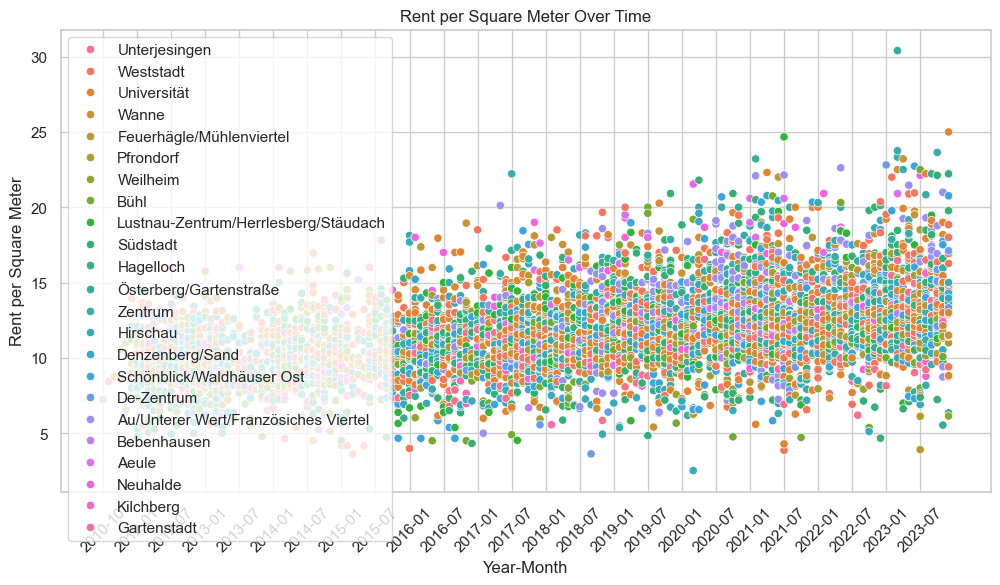

In [35]:
df_w_loc_interesting = df_w_loc[df_w_loc["oadr_u2"].isin(interesting_regions)]
# scatter plot with seaborn
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.scatterplot(data=df_w_loc_interesting, x="year_month", y="kstn_miete_kalt_pqm", hue="oadr_u2")
plt.title('Rent per Square Meter Over Time')
plt.xlabel('Year-Month')
plt.xticks(df_w_loc_interesting['year_month'].unique()[::6], rotation=45)
plt.ylabel('Rent per Square Meter')
plt.legend()
plt.show()

## Linear regression
Weil wir als X-Werte das Datum haben, können wir nicht einfach linear regression anwenden. Wir gehen wie folgt vor:
1) Wir ändern unsere Werte zu ordinalen Werten
2) Splitten x und y
3) Fitten die Kurve
4) Ploten die Kurve in die scatter plots rein

### 1) Ordinal values

In [36]:
df_w_loc_interesting_copy = df_w_loc_interesting.copy()
df_w_loc_interesting_copy["startdate"]

106718    2010-10-15
106705    2011-07-23
106694    2011-08-02
106639    2011-10-04
106630    2011-10-31
             ...    
694       2023-12-04
25        2023-12-30
118       2023-12-26
125       2023-12-25
420       2023-12-12
Name: startdate, Length: 6300, dtype: object

In [37]:
import datetime as dt
df_w_loc_interesting_copy['startdate'] = pd.to_datetime(df_w_loc_interesting_copy['startdate'])
df_w_loc_interesting_copy['startdate_ordinal']=df_w_loc_interesting_copy['startdate'].map(dt.datetime.toordinal)
df_w_loc_interesting_copy['startdate_ordinal']

106718    734060
106705    734341
106694    734351
106639    734414
106630    734441
           ...  
694       738858
25        738884
118       738880
125       738879
420       738866
Name: startdate_ordinal, Length: 6300, dtype: int64

### 2) Split x and y

In [38]:
from sklearn.linear_model import LinearRegression

In [39]:
df_w_loc_interesting_copy["kstn_miete_kalt_pqm"].isna().sum()

0

In [65]:
df_w_loc_interesting_copy["startdate"].unique()

<DatetimeArray>
['2012-03-16 00:00:00', '2012-07-09 00:00:00', '2013-01-05 00:00:00',
 '2013-01-11 00:00:00', '2013-07-06 00:00:00', '2013-08-30 00:00:00',
 '2013-09-09 00:00:00', '2016-05-16 00:00:00', '2017-01-15 00:00:00',
 '2017-06-21 00:00:00',
 ...
 '2018-12-26 00:00:00', '2019-02-13 00:00:00', '2019-03-01 00:00:00',
 '2019-06-13 00:00:00', '2020-03-21 00:00:00', '2021-06-09 00:00:00',
 '2021-11-28 00:00:00', '2022-03-18 00:00:00', '2022-07-17 00:00:00',
 '2023-09-10 00:00:00']
Length: 3079, dtype: datetime64[ns]

In [40]:
lg_df = pd.DataFrame(columns=["oadr_u2", "r_sq", "intercept", "slope"])
df_w_loc_interesting_copy=df_w_loc_interesting_copy.sort_values(by=["oadr_u2", 'startdate_ordinal'])
for i in interesting_regions:
    x = df_w_loc_interesting_copy.loc[df_w_loc_interesting_copy["oadr_u2"] == i, "startdate_ordinal"]
    
    y = df_w_loc_interesting_copy.loc[df_w_loc_interesting_copy["oadr_u2"] == i, "kstn_miete_kalt_pqm"]
    x = x.values.reshape(-1, 1)
    print(i)
    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)
    intercept = model.intercept_
    slope=model.coef_[0]
    lg_df = lg_df._append({"oadr_u2": i, "r_sq": r_sq, "intercept": intercept, "slope": slope}, ignore_index=True)
lg_df

Zentrum
Unterjesingen
Bühl
Universität
Wanne
Weilheim
De-Zentrum
Schönblick/Waldhäuser Ost
Weststadt
Österberg/Gartenstraße
Bebenhausen
Denzenberg/Sand
Pfrondorf
Südstadt
Hagelloch
Au/Unterer Wert/Französiches Viertel
Feuerhägle/Mühlenviertel
Lustnau-Zentrum/Herrlesberg/Stäudach
Hirschau
Kilchberg
Neuhalde
Aeule
Gartenstadt


,oadr_u2,r_sq,intercept,slope
0,Zentrum,0.178785,-788.834277,0.001087
1,Unterjesingen,0.285106,-649.616715,0.000895
2,Bühl,0.297118,-880.410839,0.001209
3,Universität,0.138383,-622.217234,0.000860
4,Wanne,0.236807,-714.501564,0.000986
5,Weilheim,0.236790,-555.229874,0.000767
6,De-Zentrum,0.297820,-1059.910459,0.001454
7,Schönblick/Waldhäuser Ost,0.204229,-713.434855,0.000984
8,Weststadt,0.173418,-646.016777,0.000893
9,Österberg/Gartenstraße,0.205345,-665.118626,0.000919


In [41]:
lg_df = pd.DataFrame(columns=["oadr_u2", "r_sq", "intercept", "slope", "p_val"])
df_w_loc_interesting_copy=df_w_loc_interesting_copy.sort_values(by=["oadr_u2", 'startdate_ordinal'])
for i in interesting_regions:
    x = df_w_loc_interesting_copy.loc[df_w_loc_interesting_copy["oadr_u2"] == i, "startdate_ordinal"]
    y = df_w_loc_interesting_copy.loc[df_w_loc_interesting_copy["oadr_u2"] == i, "kstn_miete_kalt_pqm"]
    test_result = linregress(x=x, y=y)
    print(test_result)
    x = x.values.reshape(-1, 1)
    print(i)
    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)
 
    intercept = model.intercept_
    slope=model.coef_[0]
    lg_df = lg_df._append({"oadr_u2": i, "r_sq": r_sq, "intercept": intercept, "slope": slope, "p_val":test_result.pvalue} ,ignore_index=True)
lg_df.sort_values(by=["slope"])

LinregressResult(slope=0.0010865238055873007, intercept=-788.8342767482856, rvalue=0.4228302607535664, pvalue=1.5516335200760753e-23, stderr=0.00010331649209668351, intercept_stderr=76.15155946555672)
Zentrum
LinregressResult(slope=0.000895370372342524, intercept=-649.6167145023774, rvalue=0.5339530599406775, pvalue=1.520385504394486e-15, stderr=0.00010285933326019487, intercept_stderr=75.76215429396683)
Unterjesingen
LinregressResult(slope=0.0012087817161538024, intercept=-880.4108394055743, rvalue=0.5450850889639777, pvalue=1.706524474814375e-17, stderr=0.00012953623111775392, intercept_stderr=95.4395493422404)
Bühl
LinregressResult(slope=0.0008603661514379388, intercept=-622.2172341429946, rvalue=0.371999075334012, pvalue=2.2382621706478006e-28, stderr=7.497070250739744e-05, intercept_stderr=55.25576106045365)
Universität
LinregressResult(slope=0.0009855562653082674, intercept=-714.5015638188784, rvalue=0.48662813122270493, pvalue=6.894743770005921e-27, stderr=8.562241661144195e-05,

,oadr_u2,r_sq,intercept,slope,p_val
16,Feuerhägle/Mühlenviertel,0.057837,-376.587480,0.000527,4.243169e-04
22,Gartenstadt,0.035663,-493.250178,0.000684,5.002780e-01
5,Weilheim,0.236790,-555.229874,0.000767,2.240223e-05
3,Universität,0.138383,-622.217234,0.000860,2.238262e-28
21,Aeule,0.079618,-628.838743,0.000872,5.200943e-02
8,Weststadt,0.173418,-646.016777,0.000893,2.552006e-31
1,Unterjesingen,0.285106,-649.616715,0.000895,1.520386e-15
12,Pfrondorf,0.270402,-649.136386,0.000897,1.603020e-20
9,Österberg/Gartenstraße,0.205345,-665.118626,0.000919,6.513297e-09
10,Bebenhausen,0.396550,-689.602340,0.000950,1.339609e-05


In [42]:
lg_df["jahresanstieg"]=lg_df["slope"]*365
lg_df

,oadr_u2,r_sq,intercept,slope,p_val,jahresanstieg
0,Zentrum,0.178785,-788.834277,0.001087,1.551634e-23,0.396581
1,Unterjesingen,0.285106,-649.616715,0.000895,1.520386e-15,0.326810
2,Bühl,0.297118,-880.410839,0.001209,1.706524e-17,0.441205
3,Universität,0.138383,-622.217234,0.000860,2.238262e-28,0.314034
4,Wanne,0.236807,-714.501564,0.000986,6.894744e-27,0.359728
5,Weilheim,0.236790,-555.229874,0.000767,2.240223e-05,0.279937
6,De-Zentrum,0.297820,-1059.910459,0.001454,1.487231e-06,0.530536
7,Schönblick/Waldhäuser Ost,0.204229,-713.434855,0.000984,1.103770e-24,0.358984
8,Weststadt,0.173418,-646.016777,0.000893,2.552006e-31,0.326015
9,Österberg/Gartenstraße,0.205345,-665.118626,0.000919,6.513297e-09,0.335550


In [43]:

# withhout slope
lg_df_lat = lg_df.drop(columns=["slope"])
lg_df_lat = lg_df_lat.sort_values(by=["jahresanstieg"])
lg_df_lat

,oadr_u2,r_sq,intercept,p_val,jahresanstieg
16,Feuerhägle/Mühlenviertel,0.057837,-376.587480,4.243169e-04,0.192535
22,Gartenstadt,0.035663,-493.250178,5.002780e-01,0.249768
5,Weilheim,0.236790,-555.229874,2.240223e-05,0.279937
3,Universität,0.138383,-622.217234,2.238262e-28,0.314034
21,Aeule,0.079618,-628.838743,5.200943e-02,0.318282
8,Weststadt,0.173418,-646.016777,2.552006e-31,0.326015
1,Unterjesingen,0.285106,-649.616715,1.520386e-15,0.326810
12,Pfrondorf,0.270402,-649.136386,1.603020e-20,0.327310
9,Österberg/Gartenstraße,0.205345,-665.118626,6.513297e-09,0.335550
10,Bebenhausen,0.396550,-689.602340,1.339609e-05,0.346790


In [184]:
print(lg_df_lat.to_latex(index=False,
                  formatters={"name": str.upper},
                  float_format="{:.3f}".format,
))

\begin{tabular}{lrrrr}
\toprule
oadr_u2 & r_sq & intercept & p_val & jahresanstieg \\
\midrule
Feuerhägle/Mühlenviertel & 0.057 & 10.622 & 0.000 & 0.193 \\
Universität & 0.136 & 9.366 & 0.000 & 0.310 \\
Aeule & 0.080 & 11.265 & 0.052 & 0.318 \\
Weststadt & 0.167 & 9.665 & 0.000 & 0.318 \\
Weilheim & 0.291 & 7.650 & 0.000 & 0.320 \\
Pfrondorf & 0.272 & 9.137 & 0.000 & 0.327 \\
Unterjesingen & 0.288 & 7.612 & 0.000 & 0.331 \\
Schönblick/Waldhäuser Ost & 0.184 & 8.634 & 0.000 & 0.339 \\
Österberg/Gartenstraße & 0.202 & 9.689 & 0.000 & 0.339 \\
Denzenberg/Sand & 0.149 & 9.389 & 0.000 & 0.356 \\
Wanne & 0.237 & 8.927 & 0.000 & 0.364 \\
Kilchberg & 0.477 & 7.452 & 0.000 & 0.377 \\
Hirschau & 0.290 & 7.754 & 0.000 & 0.377 \\
Bebenhausen & 0.420 & 7.741 & 0.000 & 0.377 \\
Zentrum & 0.172 & 8.816 & 0.000 & 0.388 \\
Südstadt & 0.209 & 8.663 & 0.000 & 0.416 \\
Hagelloch & 0.327 & 7.822 & 0.000 & 0.426 \\
Lustnau-Zentrum/Herrlesberg/Stäudach & 0.212 & 8.629 & 0.000 & 0.427 \\
Bühl & 0.305 & 6.895 

/var/folders/vx/5fczb1z530gfdp5n8z75tyy80000gn/T/ipykernel_3303/2953873384.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels[:-2], rotation=45, fontsize=10)


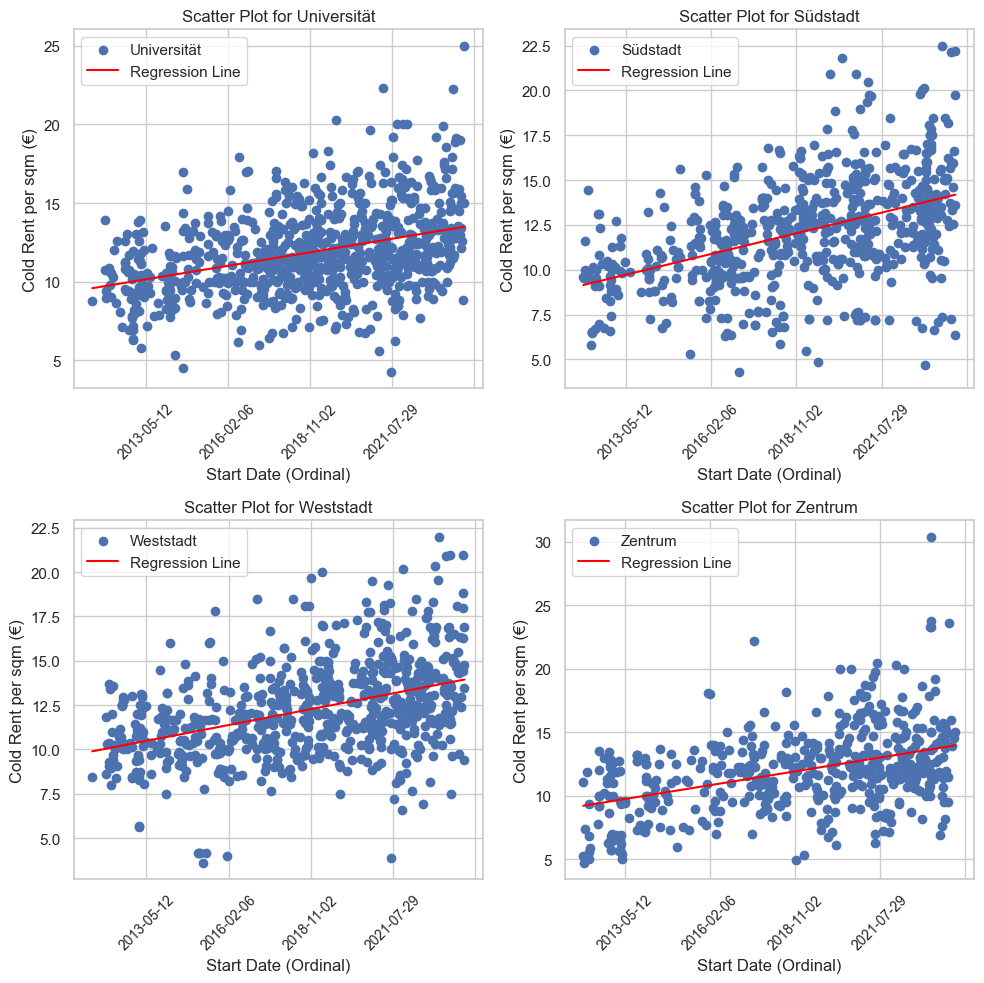

In [46]:


import matplotlib.dates as mdates
from datetime import date
# Creating scatter plot with regression line
fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # 2 rows and 2 columns of plots

for i, region in enumerate(['Universität', 'Südstadt', 'Weststadt', 'Zentrum']):
    # Filter data for each region
    region_data = df_w_loc_interesting_copy[df_w_loc_interesting_copy['oadr_u2'] == region]

    # Plotting scatter plot for each region
    ax = axs[i//2, i%2]
    ax.scatter(region_data['startdate_ordinal'], region_data['kstn_miete_kalt_pqm'], label=region)
    slope = lg_df.loc[lg_df["oadr_u2"] == region, "slope"].values[0]
    intercept = lg_df.loc[lg_df["oadr_u2"] == region, "intercept"].values[0]
    # Adding regression line
    x = np.array([region_data['startdate_ordinal'].min(), region_data['startdate_ordinal'].max()])
    y = slope * x + intercept
    ax.plot(x, y, color='red', label='Regression Line')
    new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
    ax.set_xticklabels(new_labels[:-2], rotation=45, fontsize=10)
    ax.set_title(f'Scatter Plot for {region}')
    ax.set_xlabel('Start Date (Ordinal)')
    ax.set_ylabel('Cold Rent per sqm (€)')
    ax.legend()
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    # ax.xaxis.set_major_locator(mdates.AutoDateLocator())

plt.tight_layout()
plt.show()

In [63]:
df_w_loc_interesting_copy["year"].unique()

array(['2012', '2013', '2016', '2017', '2018', '2019', '2020', '2021',
       '2022', '2023', '2014', '2015', '2011', '2010'], dtype=object)

In [61]:
df_w_loc_interesting_copy = df_w_loc_interesting_copy[df_w_loc_interesting_copy["year"] !="2024"]

/var/folders/vx/5fczb1z530gfdp5n8z75tyy80000gn/T/ipykernel_3303/4074625453.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels[:-2], rotation=45, fontsize=10)


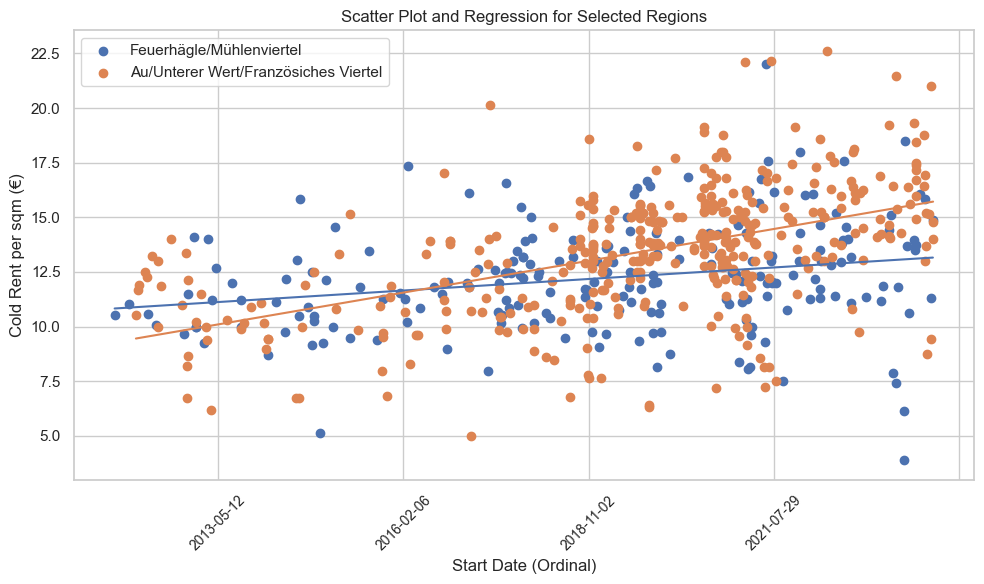

In [68]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import date

# Annahme: 'df_w_loc_interesting_copy' und 'lg_df' sind bereits definierte DataFrames
selected_regions = ['Feuerhägle/Mühlenviertel', 'Au/Unterer Wert/Französiches Viertel']

# Erstellen des Plots
fig, ax = plt.subplots(figsize=(10, 6))
scatter_plots = []  # To store scatter plot handles for the legend

for region in selected_regions:
    # Filter data for the selected region
    region_data = df_w_loc_interesting_copy[df_w_loc_interesting_copy['oadr_u2'] == region]

    # Creating scatter plot for the selected region
    scatter = ax.scatter(region_data['startdate_ordinal'], region_data['kstn_miete_kalt_pqm'], label=region)
    scatter_plots.append(scatter)

    # Calculating and plotting the regression line
    slope = lg_df.loc[lg_df["oadr_u2"] == region, "slope"].values[0]
    intercept = lg_df.loc[lg_df["oadr_u2"] == region, "intercept"].values[0]
    x = np.array([region_data['startdate_ordinal'].min(), region_data['startdate_ordinal'].max()])
    y = slope * x + intercept
    ax.plot(x, y)

# Formatting the plot
ax.set_title('Scatter Plot and Regression for Selected Regions')
ax.set_xlabel('Start Date (Ordinal)')
ax.set_ylabel('Cold Rent per sqm (€)')
new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels[:-2], rotation=45, fontsize=10)

# Creating custom legend for scatter plots only
ax.legend(handles=scatter_plots, labels=selected_regions)

plt.tight_layout()
plt.show()


## Gesamt regression für Tübingen

### Ich nehme jetzt den gesamten Datensatz, nicht nur die wo wir für oadr_u2 was haben

In [72]:
df.shape

(9935, 89)

In [71]:
df_complete = df[df["kstn_miete_kalt_pqm"].notna()]

In [73]:
df_complete.shape

(9935, 89)

In [75]:
df_complete["startdate"] = pd.to_datetime(df_complete["startdate"])
df_complete["startdate_ordinal"]=df_complete["startdate"].map(dt.datetime.toordinal)
df_complete["startdate_ordinal"]

13        738884
25        738884
34        738883
36        738883
55        738882
           ...  
106694    734351
106702    734343
106705    734341
106717    734060
106718    734060
Name: startdate_ordinal, Length: 9935, dtype: int64

In [79]:
m = LinearRegression().fit(df_complete["startdate_ordinal"].values.reshape(-1, 1), df_complete["kstn_miete_kalt_pqm"])
r_sq = m.score(df_complete["startdate_ordinal"].values.reshape(-1, 1), df_complete["kstn_miete_kalt_pqm"])
print('coefficient of determination:', r_sq)
print('intercept:', m.intercept_)
print('slope:', m.coef_)

coefficient of determination: 0.22491195838808964
intercept: -759.2669890876181
slope: [0.00104639]


In [81]:
df_complete = df_complete.sort_values(by=["startdate_ordinal"])
x = df_complete["startdate_ordinal"]
y = df_complete["kstn_miete_kalt_pqm"]
model = linregress(x=x, y=y)
print(model)
tue_slope = model.slope
tue_intercept = model.intercept

LinregressResult(slope=0.0010463900979493402, intercept=-759.2669890876216, rvalue=0.474248835937517, pvalue=0.0, stderr=1.9490485088066583e-05, intercept_stderr=14.359600129868628)


## Dient nur als Verifizierung für den händisch berechnen Ansatz eins drunter

<Axes: xlabel='startdate_ordinal', ylabel='kstn_miete_kalt_pqm'>

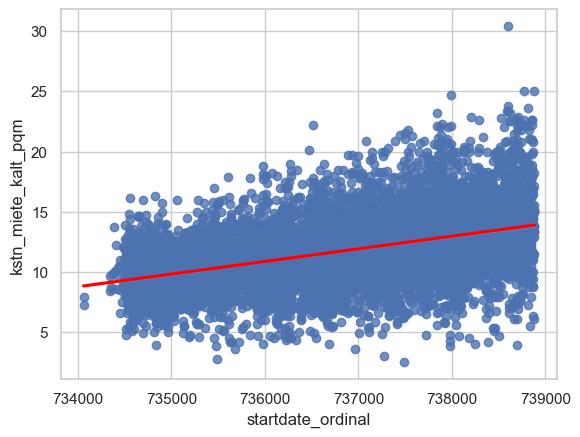

In [78]:
sns.regplot(data=df_complete, x= "startdate_ordinal", y="kstn_miete_kalt_pqm", line_kws={"color": "red"})

/var/folders/vx/5fczb1z530gfdp5n8z75tyy80000gn/T/ipykernel_3303/3337273802.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels[:-2], rotation=45, fontsize=10)


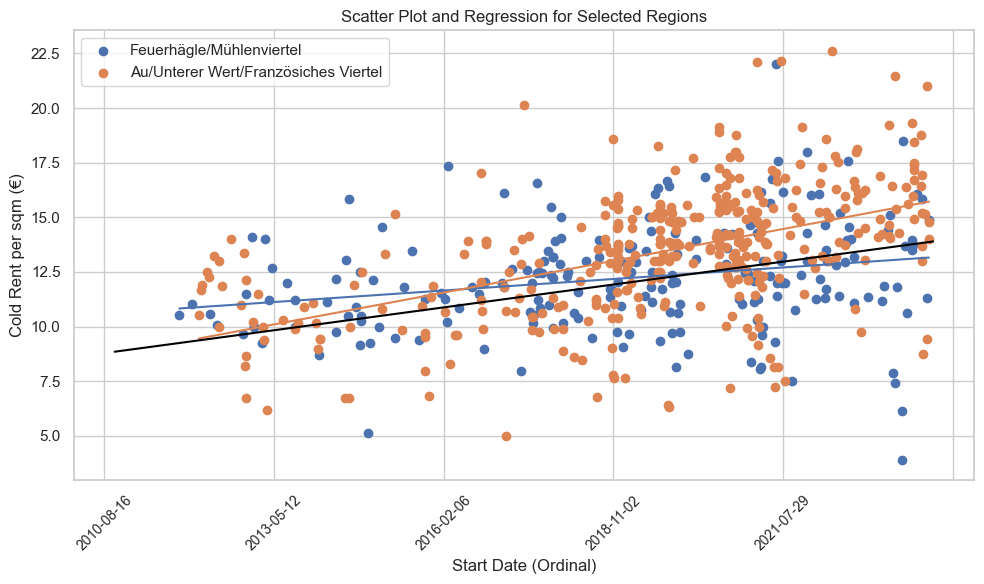

In [82]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import date

# Annahme: 'df_w_loc_interesting_copy' und 'lg_df' sind bereits definierte DataFrames
selected_regions = ['Feuerhägle/Mühlenviertel', 'Au/Unterer Wert/Französiches Viertel']

# Erstellen des Plots
fig, ax = plt.subplots(figsize=(10, 6))
scatter_plots = []  # To store scatter plot handles for the legend

for region in selected_regions:
    # Filter data for the selected region
    region_data = df_w_loc_interesting_copy[df_w_loc_interesting_copy['oadr_u2'] == region]

    # Creating scatter plot for the selected region
    scatter = ax.scatter(region_data['startdate_ordinal'], region_data['kstn_miete_kalt_pqm'], label=region)
    scatter_plots.append(scatter)

    # Calculating and plotting the regression line
    slope = lg_df.loc[lg_df["oadr_u2"] == region, "slope"].values[0]
    intercept = lg_df.loc[lg_df["oadr_u2"] == region, "intercept"].values[0]
    x = np.array([region_data['startdate_ordinal'].min(), region_data['startdate_ordinal'].max()])
    y = slope * x + intercept
    ax.plot(x, y)
   
x_tue = np.array([df_complete['startdate_ordinal'].min(), df_complete['startdate_ordinal'].max()])
y_tue = tue_slope * x_tue + tue_intercept
ax.plot(x_tue, y_tue, color="black", label="Tübingen")
# Formatting the plot
ax.set_title('Scatter Plot and Regression for Selected Regions')
ax.set_xlabel('Start Date (Ordinal)')
ax.set_ylabel('Cold Rent per sqm (€)')
new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels[:-2], rotation=45, fontsize=10)

# Creating custom legend for scatter plots only
ax.legend(handles=scatter_plots, labels=selected_regions)

plt.tight_layout()
plt.show()


/var/folders/vx/5fczb1z530gfdp5n8z75tyy80000gn/T/ipykernel_3303/6834018.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels[:-2], rotation=45, fontsize=10)


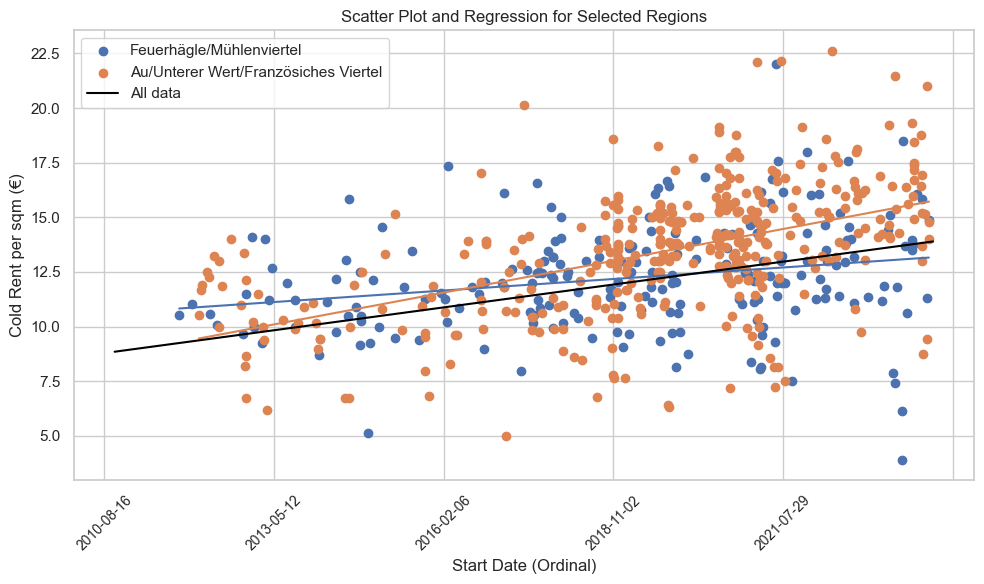

In [83]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import date

# Assuming 'df_w_loc_interesting_copy', 'lg_df', and 'df_complete' are predefined DataFrames
selected_regions = ['Feuerhägle/Mühlenviertel', 'Au/Unterer Wert/Französiches Viertel']

# Creating the plot
fig, ax = plt.subplots(figsize=(10, 6))
scatter_plots = []  # To store scatter plot handles for the legend

for region in selected_regions:
    # Filter data for the selected region
    region_data = df_w_loc_interesting_copy[df_w_loc_interesting_copy['oadr_u2'] == region]

    # Creating scatter plot for the selected region
    scatter = ax.scatter(region_data['startdate_ordinal'], region_data['kstn_miete_kalt_pqm'], label=region)
    scatter_plots.append(scatter)

    # Calculating and plotting the regression line for each region
    slope = lg_df.loc[lg_df["oadr_u2"] == region, "slope"].values[0]
    intercept = lg_df.loc[lg_df["oadr_u2"] == region, "intercept"].values[0]
    x = np.array([region_data['startdate_ordinal'].min(), region_data['startdate_ordinal'].max()])
    y = slope * x + intercept
    ax.plot(x, y)

# Adding the overall regression line for 'All data'
x_tue = np.array([df_complete['startdate_ordinal'].min(), df_complete['startdate_ordinal'].max()])
y_tue = tue_slope * x_tue + tue_intercept
line_all_data, = ax.plot(x_tue, y_tue, color="black", label="Tübingen")

# Formatting the plot
ax.set_title('Scatter Plot and Regression for Selected Regions')
ax.set_xlabel('Start Date (Ordinal)')
ax.set_ylabel('Cold Rent per sqm (€)')
new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels[:-2], rotation=45, fontsize=10)

# Creating custom legend for scatter plots and the 'All data' regression line
scatter_plots.append(line_all_data)
ax.legend(handles=scatter_plots, labels=selected_regions + ["All data"])

plt.tight_layout()
plt.show()


# F-Statistik
## General
$y= \beta_0 +  \boldsymbol{\beta} \cdot X $ <br>
$y=\beta_0+\beta_1x_1+\beta_2x_2+...+\beta_nx_n$
## Hypothesis
$H_0$: There is no relationship between the dependent and independent variable, $\beta_1=\beta_2=...=\beta_n=0$, in other words, predictor x is not able to explain the variance of the independent variable y. <br>
$H_1$: There is a relationship between the dependent and independent variable, $\beta_1 \neq 0$ or $\beta_2 \neq 0$ or ... or $\beta_n \neq 0$, in other words,  x is significant in predicting the value of y.

### Intuivly, what does the F-Statistic in our case tell us?
So, if even one of the coefficients is significant, then there is a high possibility of rejecting the null hypothesis as the coefficients are not jointly insignificant anymore. In our example, we can clearly see the slope of the line is not zero. 

## Equation
$ F=\frac{SSR_R - SSR_U / P}{SSR_U / N - P - 1}$ <br>


In [ ]:
from sklearn.feature_selection import f_regression
Y = df_w_loc_interesting_copy["kstn_miete_kalt_pqm"]
X = df_w_loc_interesting_copy["startdate_ordinal_better_scale"].values.reshape(-1, 1)
f_stat, p_val = f_regression(X, Y)
print(f"p-value: {p_val}")
print(f"f-statistic: {f_stat}")


p-value: [2.12258322e-94]
f-statistic: [468.22063241]


In [52]:
import statsmodels.api as sm

In [ ]:
import statsmodels.api as sm
X = df_w_loc_interesting_copy["startdate_ordinal_better_scale"]
X = sm.add_constant(X)
Y = df_w_loc_interesting_copy["kstn_miete_kalt_pqm"]
model = sm.OLS(Y, X).fit()
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     kstn_miete_kalt_pqm   R-squared:                       0.174
Model:                             OLS   Adj. R-squared:                  0.173
Method:                  Least Squares   F-statistic:                     468.2
Date:                 Tue, 23 Jan 2024   Prob (F-statistic):           2.12e-94
Time:                         14:09:34   Log-Likelihood:                -5230.1
No. Observations:                 2229   AIC:                         1.046e+04
Df Residuals:                     2227   BIC:                         1.048e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
co

## Interpretation
In this, we can check the p-value (listed as Prob F-statistic) in the summary to determine whether to reject or accept the null hypothesis. Here the p-value is the probability that the null hypothesis for the full model is true (i.e., that all of the regression coefficients are zero). Since the p-value is approximately zero, we reject the null hypothesis. In other words, there is evidence that suggests that there is a linear relationship between price and the "set" of predictor variables (in our case just time).

# Watch out though, F-Test cares for multiple variables, we only have one
# We should probably use the t-test instead

# Regression T-Test
The regression t-test is applied to test if the slope, β, of the population regression line equals 0. Based on that test, we may decide whether x is a useful (linear) predictor of y.
The test-statistic follows a t-distribution with n-2 df and is defined as:

$$t=\frac{{\beta}}{s_b} = \frac{\beta}{s_e/\sqrt{\sum{(x-\hat x)^2}}}$$


# Dates on x-axis

9.365588007307949
8.662961605885487
9.665155271020023
8.815731311307571


/var/folders/vx/5fczb1z530gfdp5n8z75tyy80000gn/T/ipykernel_1377/1520639020.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels[:-2], rotation=45, fontsize=10)


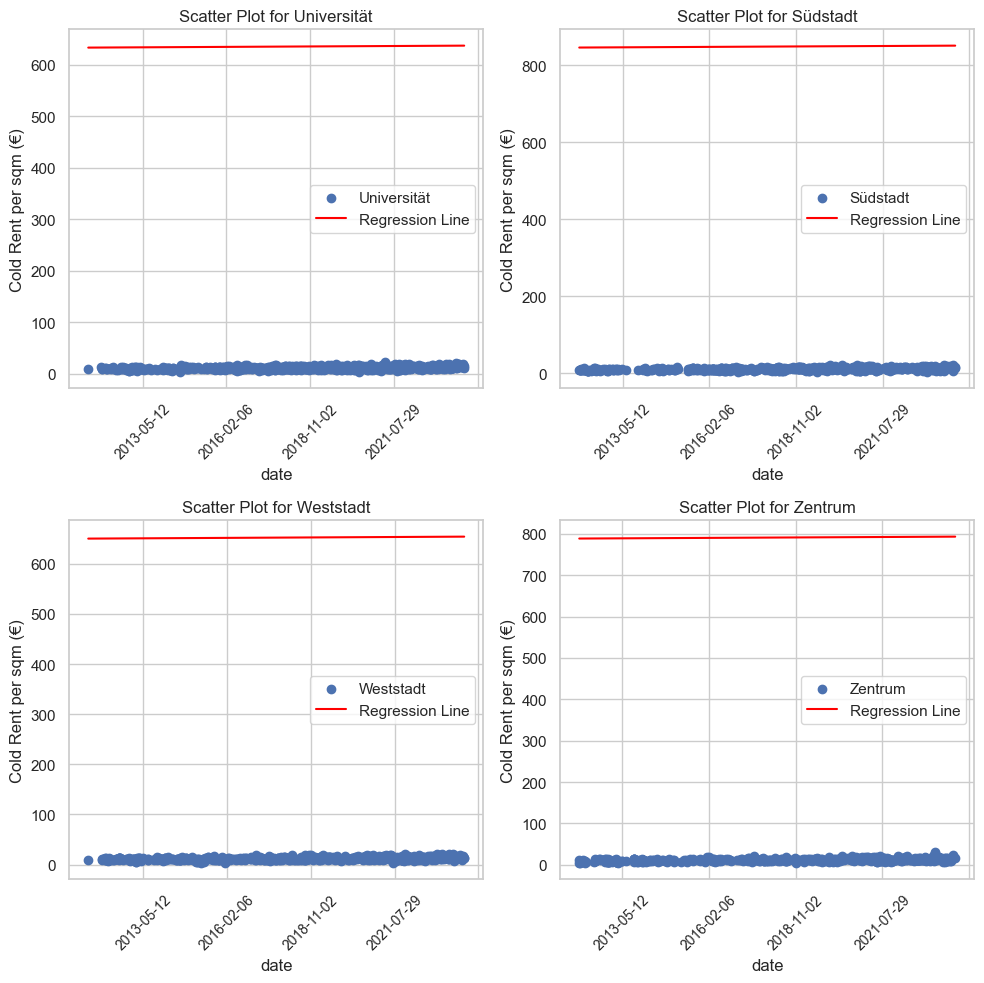

In [173]:


import matplotlib.dates as mdates
from datetime import date
# Creating scatter plot with regression line
fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # 2 rows and 2 columns of plots

for i, region in enumerate(['Universität', 'Südstadt', 'Weststadt', 'Zentrum']):
    # Filter data for each region
    region_data = df_w_loc_interesting_copy[df_w_loc_interesting_copy['oadr_u2'] == region]

    # Plotting scatter plot for each region
    ax = axs[i//2, i%2]
    ax.scatter(region_data['startdate_ordinal'], region_data['kstn_miete_kalt_pqm'], label=region)
    slope = lg_df.loc[lg_df["oadr_u2"] == region, "slope"].values[0]
    intercept = lg_df.loc[lg_df["oadr_u2"] == region, "intercept"].values[0]
    # Adding regression line
    x = np.array([region_data['startdate_ordinal'].min(), region_data['startdate_ordinal'].max()])
    y = slope * x + intercept
    print(intercept)
    ax.plot(x, y, color='red', label='Regression Line')
    
    ax.set_title(f'Scatter Plot for {region}')
    ax.set_xlabel('Start Date (Ordinal)')
    ax.set_xlabel('date')
    new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
    ax.set_xticklabels(new_labels[:-2], rotation=45, fontsize=10)
    ax.set_ylabel('Cold Rent per sqm (€)')
    ax.legend()
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    # ax.xaxis.set_major_locator(mdates.AutoDateLocator())

plt.tight_layout()
plt.show()